In [1]:
import DeePore as dp
# Retrain and test the model: 
# If you want to try you own architecture of neural network or retrain the present one
# 1. check or download the compact data
# Data_compact='Data\DeePore_Compact_Data.h5'
Data_compact = '/home/featurize/work/DeePore_Compact_Data.h5'
# dp.check_get('https://zenodo.org/record/4297035/files/DeePore_Compact_Data.h5?download=1',Data_compact) 

# 2. prepare the dataset by removing outliers and creating list of training, evaluation and test samples
List=dp.prep(Data_compact)
TrainList, EvalList, TestList = dp.splitdata(List)

print('over 2')

2023-08-08 07:31:28.437762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 07:31:29.173887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Cheching the data for outliers. Please wait...
checking sample0
checking sample100
checking sample200
checking sample300
checking sample400
checking sample500
checking sample600
checking sample700
checking sample800
checking sample900
checking sample1000
checking sample1100
checking sample1200
checking sample1300
checking sample1400
checking sample1500
checking sample1600
checking sample1700
checking sample1800
checking sample1900
checking sample2000
checking sample2100
checking sample2200
checking sample2300
checking sample2400
checking sample2500
checking sample2600
checking sample2700
checking sample2800
checking sample2900
checking sample3000
checking sample3100
checking sample3200
checking sample3300
checking sample3400
checking sample3500
checking sample3600
checking sample3700
checking sample3800
checking sample3900
checking sample4000
checking sample4100
checking sample4200
checking sample4300
checking sample4400
checking sample4500
checking sample4600
checking sample4700
check

In [2]:
import h5py
import numpy as np
import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D
# from tensorflow.keras.models import Model
from keras.layers import Conv2D, Input, MaxPooling2D
from keras.models import Model

from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.models import Model

# from keras.layers import Flatten
from tensorflow.keras.layers import Flatten


import os, sys
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import scipy.io as sio
from scipy.ndimage import distance_transform_edt as distance
# import tensorflow.keras.backend as kb
import keras.backend as kb

from DeePore import hdf_shapes, nowstr, now, gener


# import cv2

In [3]:
import yl as yl

In [4]:
ModelType = 0

In [5]:
def modelmake(INPUT_SHAPE, OUTPUT_SHAPE, ModelType = ModelType):
    if ModelType == 729:
        model = own.MyResNet(INPUT_SHAPE, OUTPUT_SHAPE)
    if ModelType == 801:
        model = own.MyVGGNet(INPUT_SHAPE, OUTPUT_SHAPE)
    if ModelType == 2000:
        model = own.MyDenseNet(INPUT_SHAPE, OUTPUT_SHAPE)
    if ModelType == 2001:
        model = own.MyGoogleNet(INPUT_SHAPE, OUTPUT_SHAPE)
    if ModelType == 7:
        model = own.MyMobileNet(INPUT_SHAPE, OUTPUT_SHAPE)
    if ModelType == 10:
        model = own.MyEfficientNet(INPUT_SHAPE, OUTPUT_SHAPE)
    return model


def loadmodel(ModelType = 2000): # model type 3 seems to be the better one
    Path='Model'+str(ModelType)+'.h5';
    MIN,MAX=np.load('minmax.npy')
    INPUT_SHAPE=[1,128,128,3];
    OUTPUT_SHAPE=[1,1515,1];
    model=modelmake(INPUT_SHAPE,OUTPUT_SHAPE,ModelType)
    model.load_weights(Path)
    return model


def trainmodel(DataName, TrainList, EvalList, retrain=0, reload=0, epochs=100, batch_size=100, ModelType = ModelType):
    # from tensorflow.keras.callbacks import ModelCheckpoint
    from keras.callbacks import ModelCheckpoint
    MIN, MAX = np.load('minmax.npy')
    SaveName = 'Model' + str(ModelType) + '.h5';
    INPUT_SHAPE, OUTPUT_SHAPE = hdf_shapes(DataName, ('X', 'Y'));
    OUTPUT_SHAPE = [1, 1]
    # callbacks
    timestr = nowstr()
    LogName = 'log_' + timestr + '_' + 'Model' + str(ModelType)
    filepath = SaveName
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_freq=50, save_best_only=True, mode='min')

    # 创建'Logs'文件夹
    if not os.path.exists("Logs"):
        os.makedirs("Logs")

    with open("Logs/" + LogName + ".txt", "wt") as f:
        f.write('# Path to train file: \n')
        f.write(DataName + '\n')
        f.write('# Start time: \n')
        f.write(timestr + '\n')
        nowstr()
        st = '# Training loss'
        spa = ' ' * (40 - len(st))
        st = st + spa + 'Validation loss'
        f.write(st + '\n')

    class MyCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            self.val_loss_ = None
            self.start_time = now()

        def on_batch_end(self, batch, logs=None):
            if self.val_loss_ == None:
                self.val_loss_ = logs['mse']
            with open("Logs/" + LogName + ".txt", "a") as f:
                st = str(logs['mse'])
                spa = ' ' * (40 - len(st))
                st = st + spa + str(self.val_loss_)
                f.write(st + '\n')

        def on_test_batch_end(self, batch, logs=None):
            self.val_loss_ = logs['mse']

    callbacks_list = [checkpoint, MyCallback()]
    callbacks_list = [checkpoint]
    callbacks_list = []
    callbacks_list = [MyCallback()]
    # end of callbacks
    model = modelmake(INPUT_SHAPE, OUTPUT_SHAPE, ModelType = ModelType)

    if retrain:
        if reload:
            model.load_weights(SaveName)

        model.fit(gener(batch_size, DataName, TrainList, MIN, MAX), epochs=epochs,
                  steps_per_epoch=int(len(TrainList) / batch_size),
                  validation_data=gener(batch_size, DataName, EvalList, MIN, MAX),
                  validation_steps=int(len(EvalList) / batch_size), callbacks=callbacks_list)
        model.save_weights(SaveName);
    else:
        model.load_weights(SaveName)
    return model


def testmodel(model,DataName,TestList,ModelType = ModelType):
    MIN,MAX=np.load('minmax.npy')
    G=gener(len(TestList),DataName,TestList,MIN,MAX)
    L=next(G)
    x=L[0]
    y=L[1]
    y2=model.predict(L[0])
    print('\n# Evaluate on '+ str(TestList.shape[0]) + ' test data')
    model.evaluate(x,y,batch_size=50)
    #  Denormalize the predictions
    MIN=np.reshape(MIN,(1,y.shape[1]))
    MAX=np.reshape(MAX,(1,y.shape[1]))
    y=np.multiply(y,(MAX-MIN))+MIN
    y2=np.multiply(y2,(MAX-MIN))+MIN
    y[:,0:15]=10**y[:,0:15]
    y2[:,0:15]=10**y2[:,0:15]

    # save test results as mat file for postprocessing with matlab
    import scipy.io as sio
    sio.savemat('Tested_Data_Model'+str(ModelType)+'.mat',{'y':y,'y2':y2})
    # #  Show prediction of 15 single-value features
    fig=plt.figure(figsize=(30,40))
    plt.rcParams.update({'font.size': 30})
    with open('VarNames.txt') as f:
        VarNames = list(f)
    for I in range(15):
        ax = fig.add_subplot(5,3,I+1)
        X=y[:,I]
        Y=y2[:,I]
        plt.scatter(X,Y)
        plt.ylabel('Predicted')
        plt.xlabel('Ground truth')
        plt.tick_params(direction="in")
        plt.text(.5,.9,VarNames[I],horizontalalignment='center',transform=ax.transAxes)
        plt.xlim(np.min(X),np.max(X))
        plt.ylim(np.min(Y),np.max(Y))
        if I==0:
            ax.set_yscale('log')
            ax.set_xscale('log')
    plt.savefig('images/Single-value_Features.png')


print('over 729')

over 729


Epoch 1/15
113/113 [==============================] - 107s 931ms/step - loss: 0.1456 - mse: 0.1456 - val_loss: 0.1289 - val_mse: 0.1289
Epoch 2/15
113/113 [==============================] - 86s 771ms/step - loss: 0.0828 - mse: 0.0828 - val_loss: 0.0746 - val_mse: 0.0746
Epoch 3/15
113/113 [==============================] - 87s 776ms/step - loss: 0.0739 - mse: 0.0739 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 4/15
113/113 [==============================] - 89s 797ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 0.0739 - val_mse: 0.0739
Epoch 5/15
113/113 [==============================] - 83s 744ms/step - loss: 0.0735 - mse: 0.0735 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 6/15
113/113 [==============================] - 84s 748ms/step - loss: 0.0733 - mse: 0.0733 - val_loss: 0.0736 - val_mse: 0.0736
Epoch 7/15
113/113 [==============================] - 88s 783ms/step - loss: 0.0733 - mse: 0.0733 - val_loss: 0.0735 - val_mse: 0.0735
Epoch 8/15
113/113 [==============================] - 

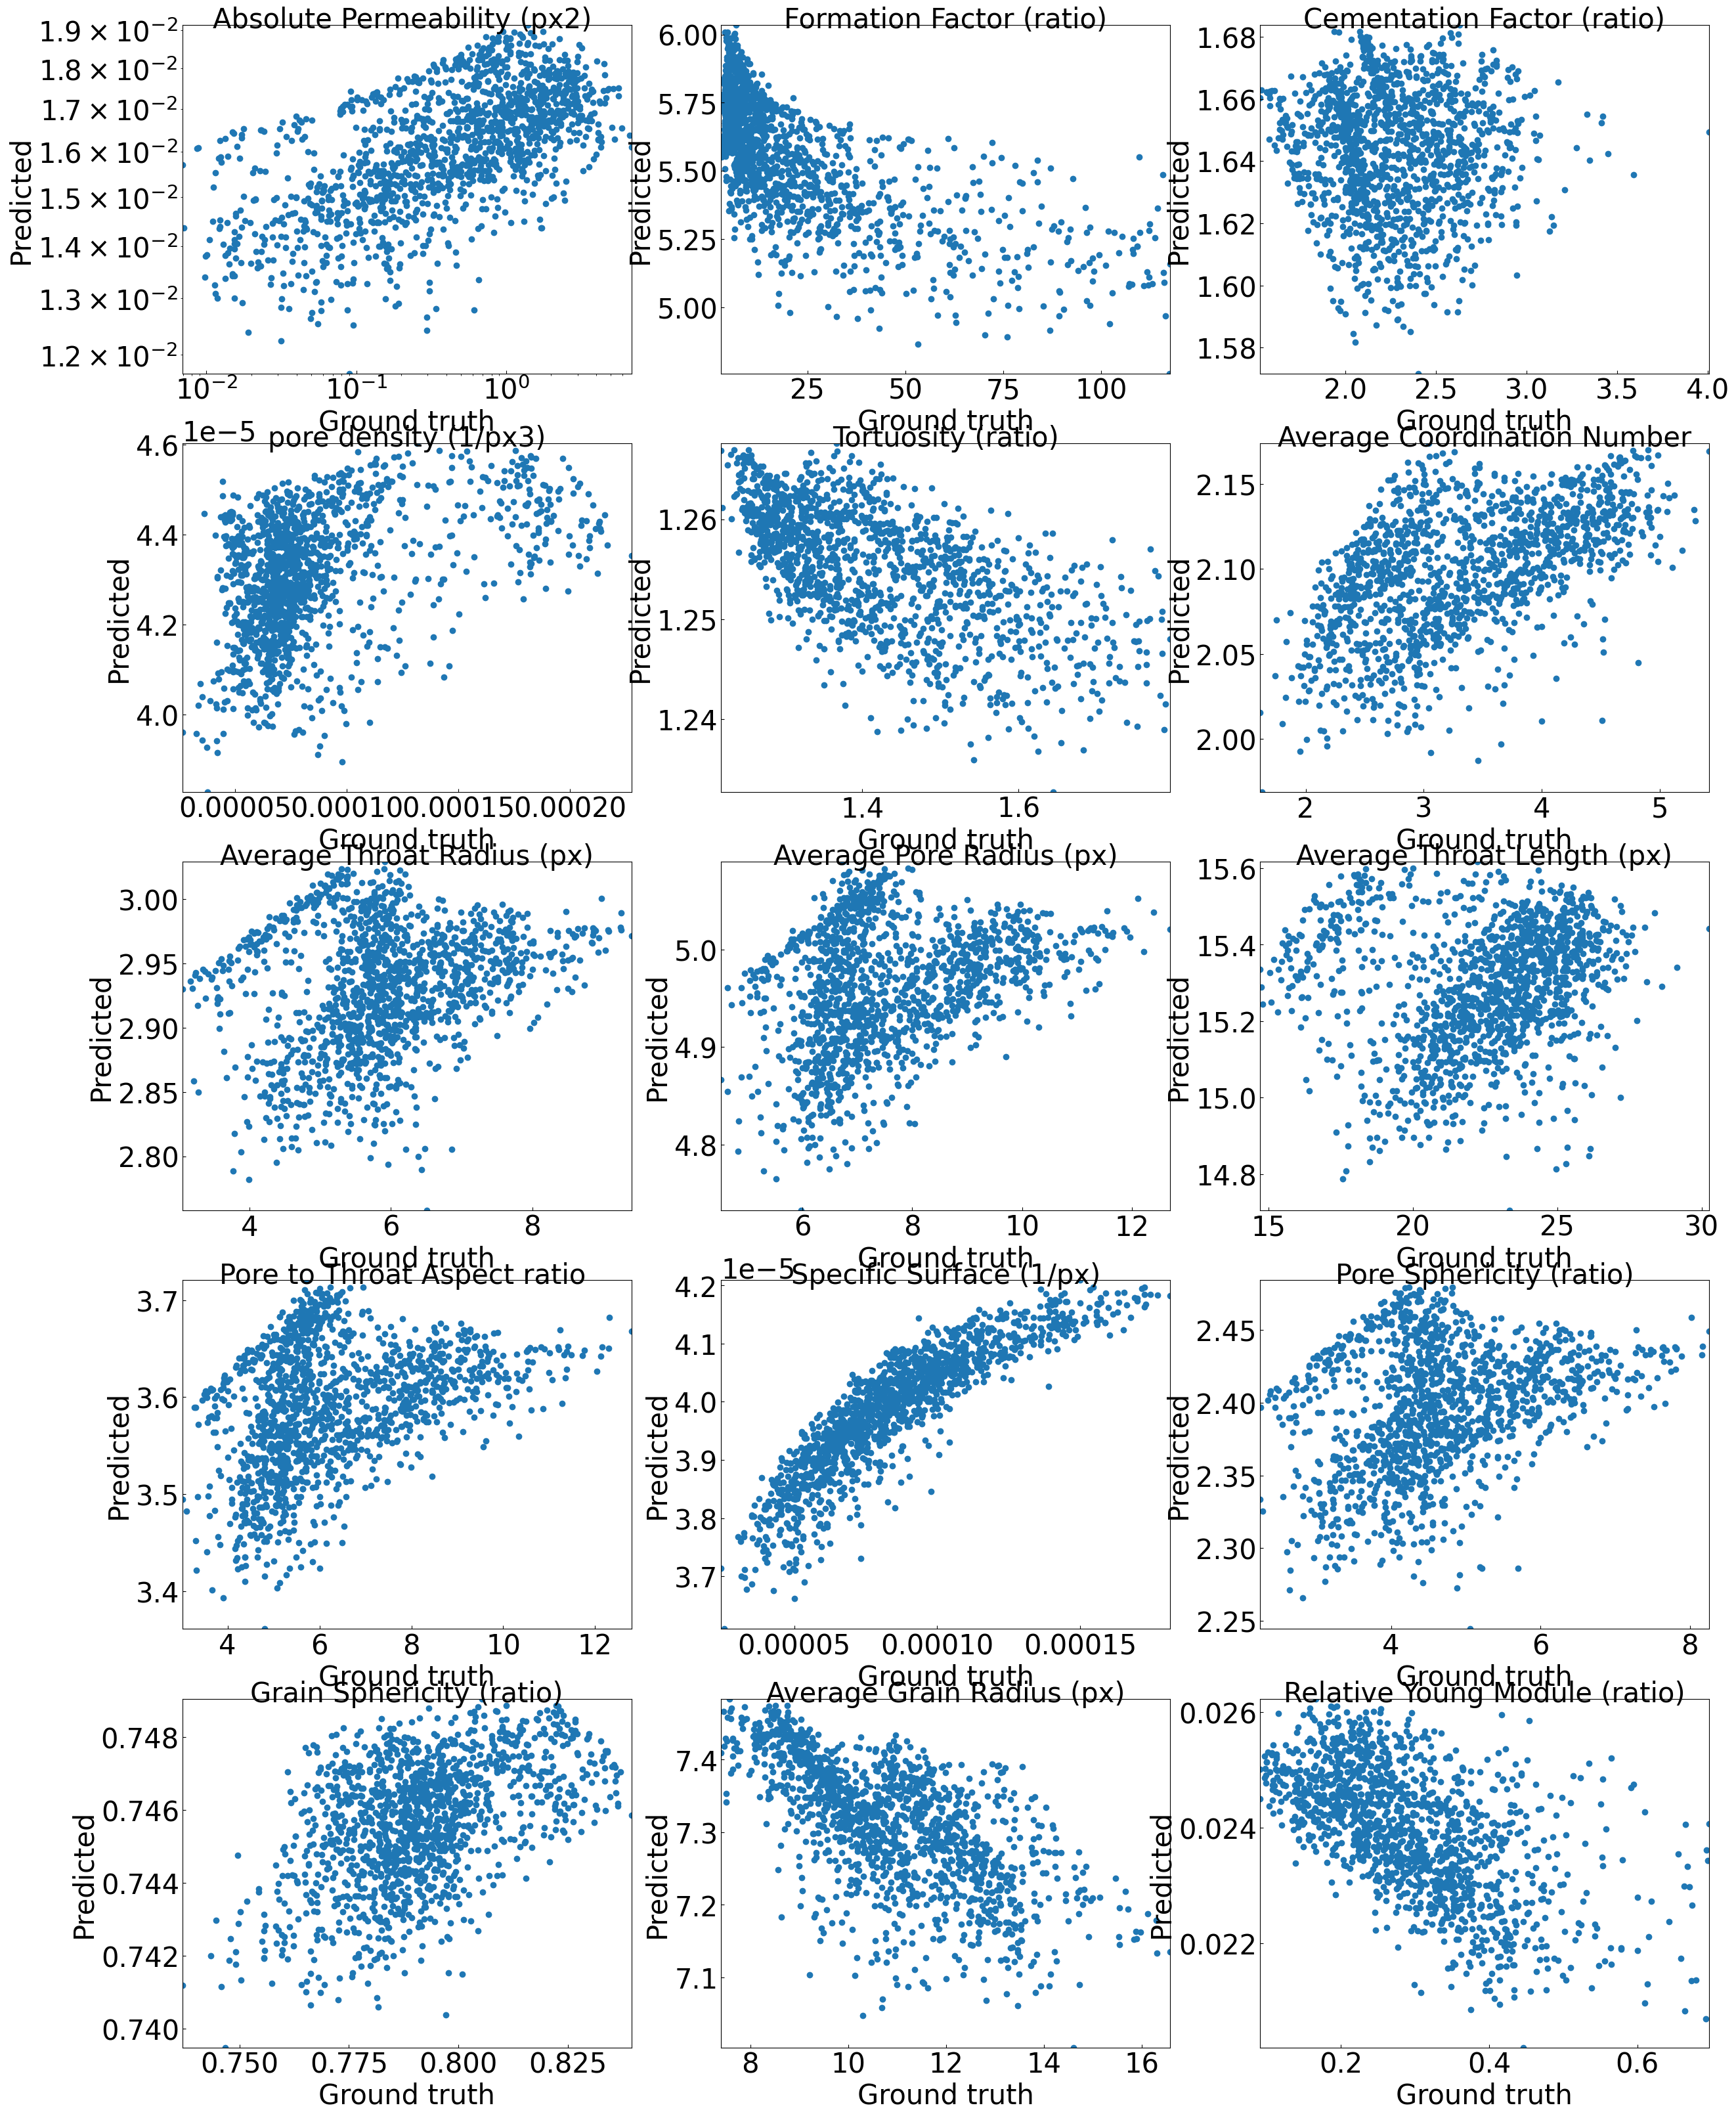

In [5]:
# VGGNet

model=yl.trainmodel(Data_compact,TrainList,EvalList,retrain=1,epochs=15,batch_size=100,ModelType=801)
yl.testmodel(model, Data_compact, TestList)

print('\n VGGNet over ')

In [6]:
# VGGNet

ModelType=801

model=trainmodel(Data_compact,TrainList,EvalList,retrain=0,epochs=15,batch_size=100,ModelType = ModelType)
testmodel(model, Data_compact, TestList, ModelType = ModelType)

print('\n VGGNet over ')

2023-08-08 07:31:54.017392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-08 07:31:54.021185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-08 07:31:54.021349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ValueError: Layer count mismatch when loading weights from file. Model expected 29 layers, found 16 saved layers.

45/45 [==============================] - 0s 3ms/step

# Evaluate on 1418 test data
29/29 [==============================] - 0s 6ms/step - loss: 0.0062 - mse: 0.0062

 ResNet over 


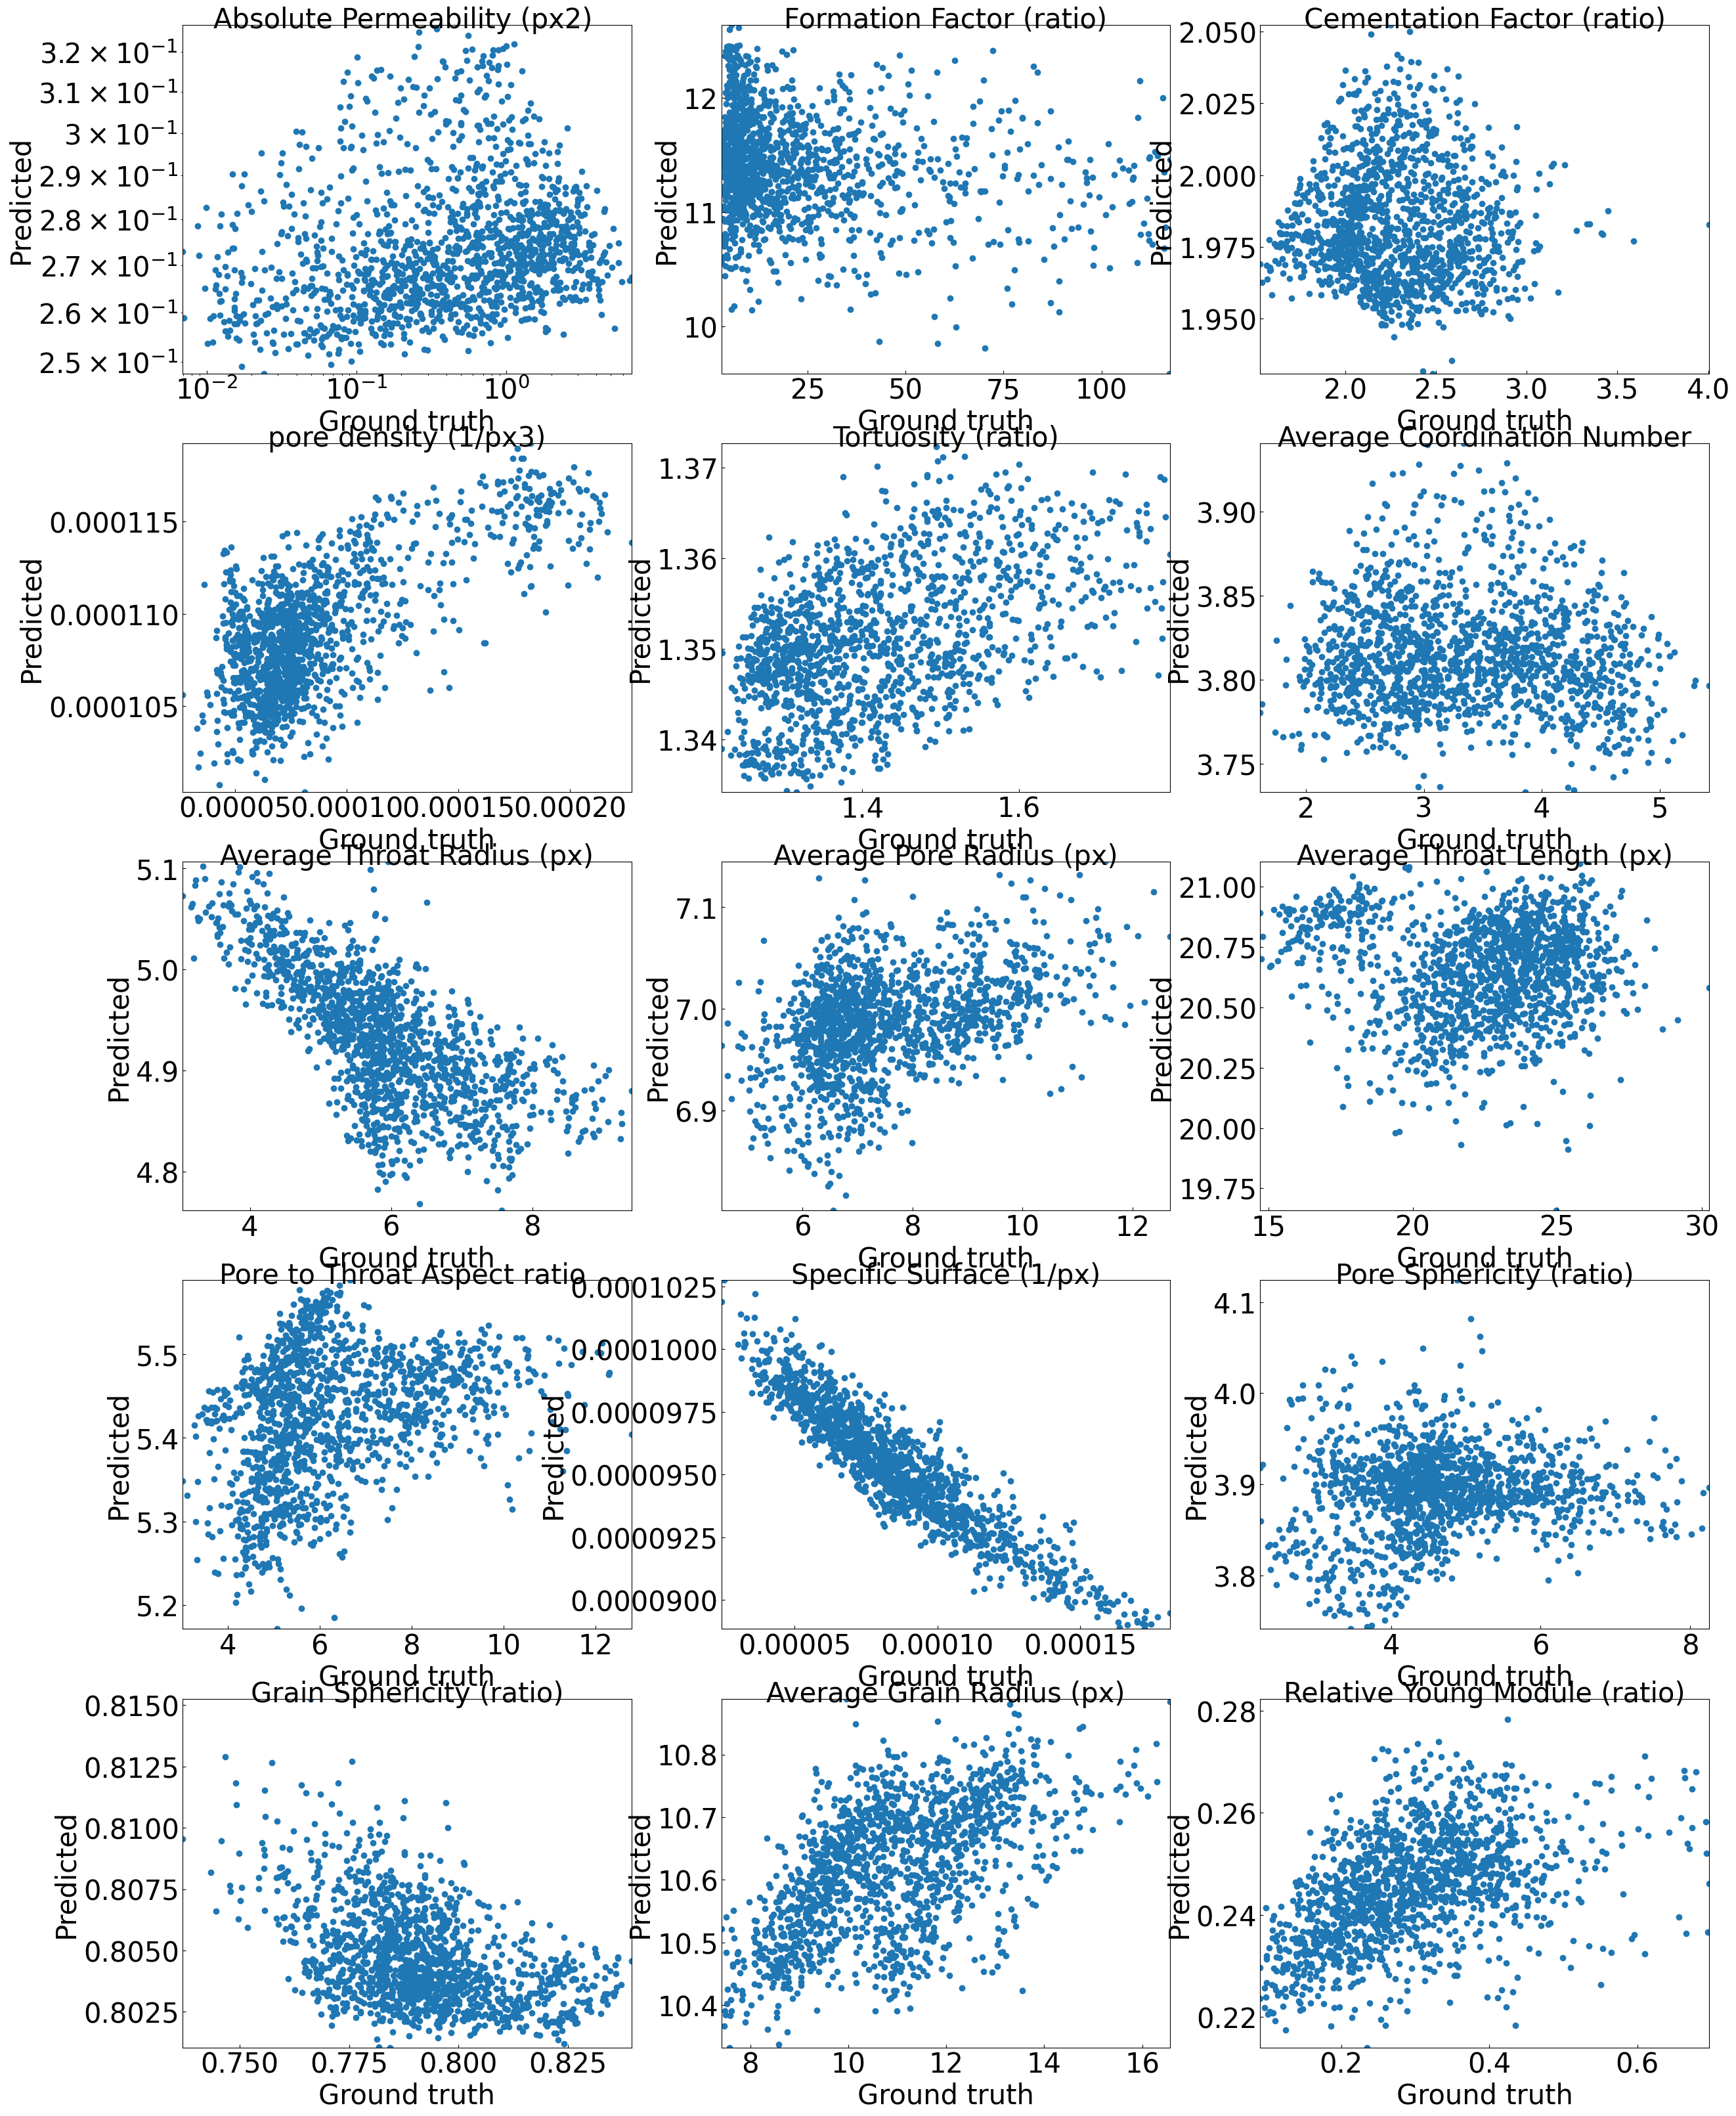

In [8]:
# ResNet

ModelType = 729

model=trainmodel(Data_compact,TrainList,EvalList,retrain=0,epochs=15,batch_size=100,ModelType=ModelType)
testmodel(model, Data_compact, TestList, ModelType=ModelType)

print('\n ResNet over ')

In [15]:
# DenseNet

ModelType = 2000

model=trainmodel(Data_compact,TrainList,EvalList,retrain=1,epochs=50,batch_size=100,ModelType=ModelType)
testmodel(model, Data_compact, TestList, ModelType=ModelType)

print('\n DenseNet over ')

ValueError: Input 0 of layer "conv2d_107" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 128)

In [16]:
# GoogleNet

ModelType = 2001

model=trainmodel(Data_compact,TrainList,EvalList,retrain=1,epochs=50,batch_size=100,ModelType=ModelType)
testmodel(model, Data_compact, TestList, ModelType=ModelType)

print('\n GoogleNet over ')

ValueError: Exception encountered when calling layer "average_pooling2d" (type AveragePooling2D).

Negative dimension size caused by subtracting 7 from 4 for '{{node average_pooling2d/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 7, 7, 1]](Placeholder)' with input shapes: [?,4,4,704].

Call arguments received by layer "average_pooling2d" (type AveragePooling2D):
  • inputs=tf.Tensor(shape=(None, 4, 4, 704), dtype=float32)

In [17]:
# MobileNet

ModelType = 7

model=trainmodel(Data_compact,TrainList,EvalList,retrain=1,epochs=50,batch_size=100,ModelType=ModelType)
testmodel(model, Data_compact, TestList, ModelType=ModelType)

print('\n MobileNet over ')

TypeError: conv_block() missing 1 required positional argument: 'kernel_size'

Epoch 1/10
113/113 [==============================] - 99s 784ms/step - loss: 0.0750 - mse: 0.0750 - val_loss: 0.1026 - val_mse: 0.1026
Epoch 2/10
113/113 [==============================] - 86s 768ms/step - loss: 0.0732 - mse: 0.0732 - val_loss: 0.0811 - val_mse: 0.0811
Epoch 3/10
113/113 [==============================] - 93s 829ms/step - loss: 0.0730 - mse: 0.0730 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 4/10
113/113 [==============================] - 89s 794ms/step - loss: 0.0729 - mse: 0.0729 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 5/10
113/113 [==============================] - 84s 749ms/step - loss: 0.0728 - mse: 0.0728 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 6/10
113/113 [==============================] - 83s 745ms/step - loss: 0.0728 - mse: 0.0728 - val_loss: 0.0764 - val_mse: 0.0764
Epoch 7/10
113/113 [==============================] - 86s 766ms/step - loss: 0.0728 - mse: 0.0728 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 8/10
113/113 [==============================] - 8

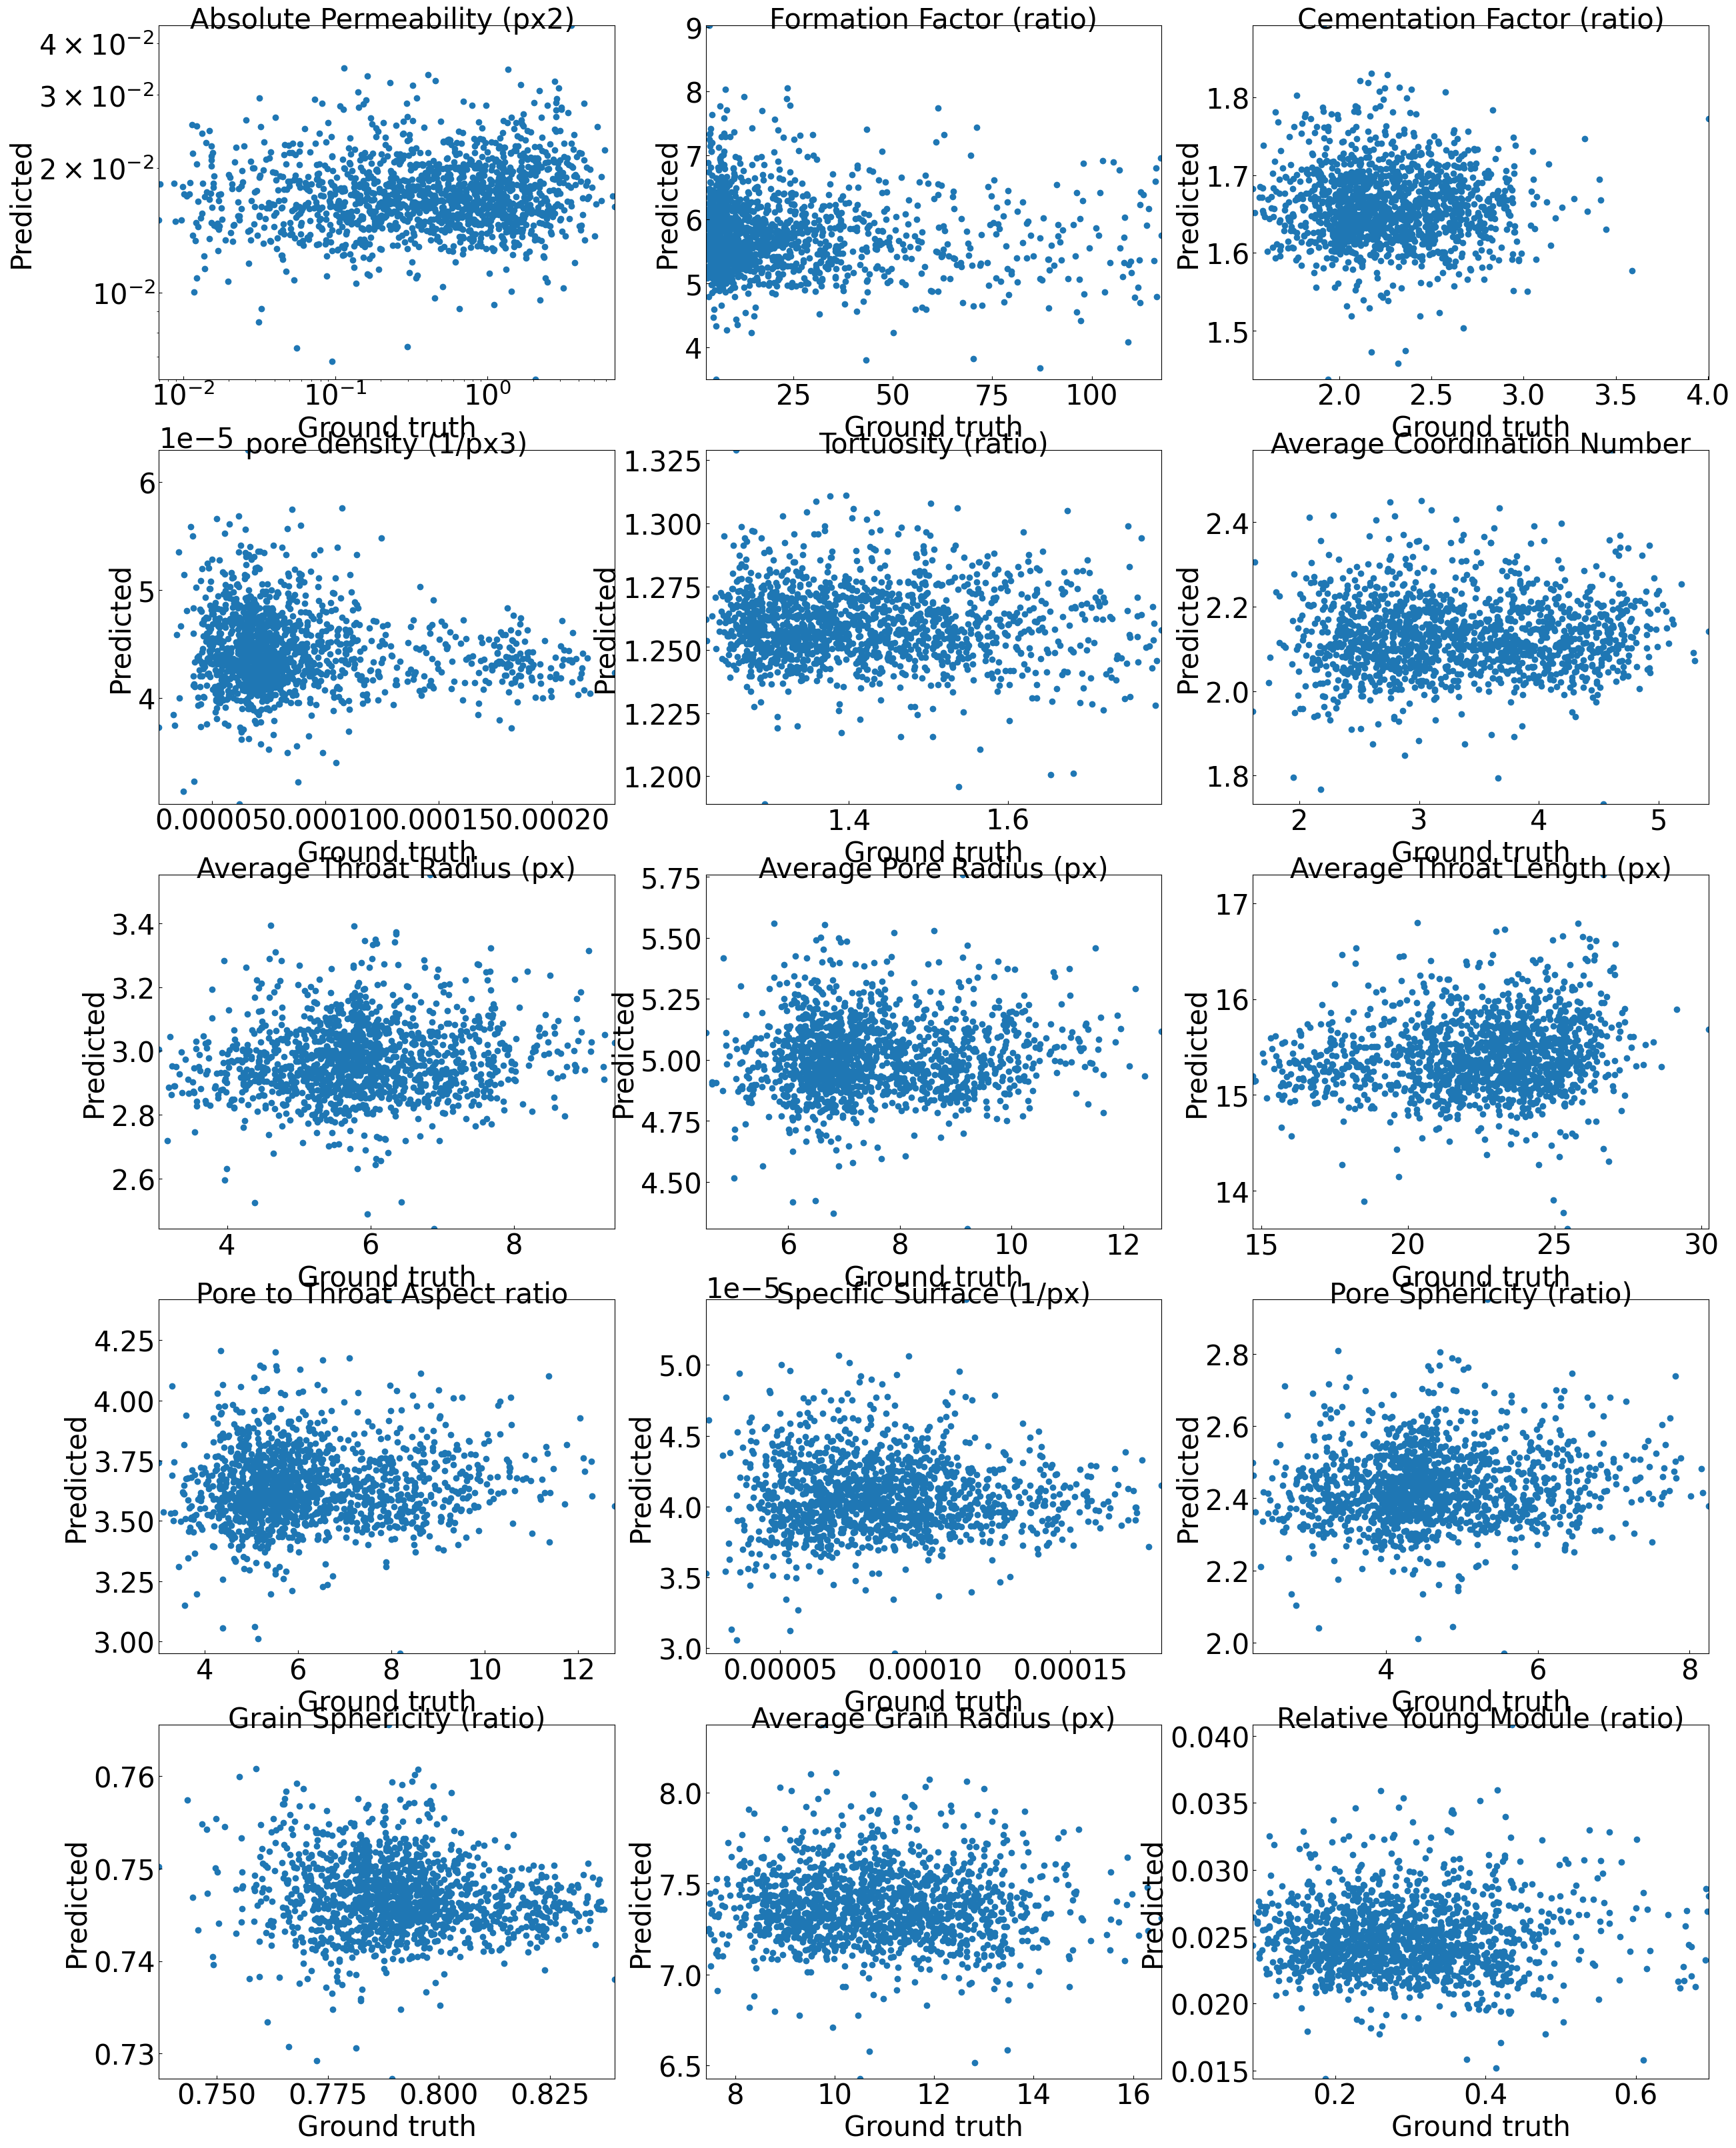

In [20]:
# EfficientNet

ModelType = 10

model=trainmodel(Data_compact,TrainList,EvalList,retrain=1,epochs=10,batch_size=100,ModelType=ModelType)
testmodel(model, Data_compact, TestList, ModelType=ModelType)

print('\n EfficientNet over ')